# Collaborative Filtering 基于协同过滤的推荐系统
Dataset：Movielens（https://grouplens.org/datasets/movielens/ ）  
Python3  
Reference：    
https://web.stanford.edu/class/cs345a/slides/03-recomsys.pdf    
http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/    
http://blog.csdn.net/pipisorry/article/details/51788955  

## 基于用户的CF：

  
对于一个用户u，首先找到与其相似的一个用户集u'，这个相似是通过它们的评分rating来判定的，likes和dislikes越相似，他们就越相似。然后，用户u
对某部电影的评价为相似用户集对这部电影评价的加权和，权重为相似度。最后向用户U推荐预测评价最高的n部电影。
UserCF的两个假设:  
1个人品味稳定或者和品味相同的人同步迁移  
2UserCF推荐系统中的item要是同一个领域中  




## 基于物品CF：
给用户推荐那些和他们之前喜欢的物品相似的物品。不过，ItemCF算法并不利用物品的内容属性计算物品之间的相似度，它主要通过分析用户的行为记录计算物品之间的相似度（如评价）。给定用户u和物品i，找到与物品i相似的物品集并计算相似度，用户u对物品i的评价为 用户u对相似物品集的评价加权和，权重为物品的相似度。

ItemCF的假设：
用户品味遵从大多数人的品味。（否则如果你的品味太奇特，只有你一个人喜欢这个item，这样就没法通过其它用户行为计算这个item与其它item的相似性）     

ItemCF的缺陷：   
低新颖性，对比基于用户的推荐，ItemCF很难带来新颖的item，往往推荐与之前购买过相似的东西 

ItemCF的优势：  
1缺陷也是优势，推荐的东西更具个性化  
2user远大于item时，可以提前计算出item之间的相似度保存着（item间的相似性没有user那么容易变化）  
3预测的效果更好

# User-User 和 Item-Item 的CF推荐优缺点比较
Reference：http://blog.csdn.net/pipisorry/article/details/51788955  

| | 	UserCF | ItemCF | 
| - | :-: | -: | 
| 性能 | 适用于用户较少的场合，如果用户过多，计算用户相似度矩阵的代价交大| 适用于物品数明显小于用户数的场合，如果物品很多，计算物品相似度矩阵的代价交大 | 
| 领域 | 实效性要求高，用户个性化兴趣要求不高 | 长尾物品丰富，用户个性化需求强烈| 
| 实时性 | 用户有新行为，不一定需要推荐结果立即变化 | 用户有新行为，不一定需要推荐结果立即变化|
| 冷启动 | 在新用户对少的物品产生行为后，不能立即对他进行个性化推荐，因为用户相似度是离线计算的；新物品上线后一段时间，一旦有用户对物品产生行为，就可以将新物品推荐给其他用户|新用户只要对一个物品产生行为，就能推荐相关物品给他，但无法在不离线更新物品相似度表的情况下将新物品推荐给用户（但是新的item到来也同样是冷启动问题）|
| 推荐理由 | 很难提供令用户信服的推荐解释 | 可以根据用户历史行为归纳推荐理由|

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import requests
import json
from IPython.display import Image
from IPython.display import display

首先读取数据集Rating，里面包含了用户对各电影的评价  
总共有10W条评价信息


In [16]:
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')
print(df_ratings.shape)
print(df_ratings.describe())
df_ratings.head(5)

(100004, 4)
              userId        movieId         rating     timestamp
count  100004.000000  100004.000000  100004.000000  1.000040e+05
mean      347.011310   12548.664363       3.543608  1.129639e+09
std       195.163838   26369.198969       1.058064  1.916858e+08
min         1.000000       1.000000       0.500000  7.896520e+08
25%       182.000000    1028.000000       3.000000  9.658478e+08
50%       367.000000    2406.500000       4.000000  1.110422e+09
75%       520.000000    5418.000000       4.000000  1.296192e+09
max       671.000000  163949.000000       5.000000  1.476641e+09


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


看一下有多少用户和电影

In [17]:

n_users = df_ratings.userId.unique().shape[0]
n_items = df_ratings.movieId.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_items) + ' movies')

671 users
9066 movies


userId从1到671，movieId从1到163949  
为了减少后期内存的使用，我们将movieId做一个映射

In [18]:
movie_map = df_ratings[['movieId']].drop_duplicates().reset_index()
MAPID = pd.DataFrame(np.arange(1,n_items+1).reshape(n_items,1),columns=['mapid'])
movie_map['mapid'] = MAPID['mapid']
movie_map.drop('index',axis=1, inplace=True)
df_ratings = pd.merge(df_ratings,movie_map, on = ['movieId'],how = 'left')
df_ratings['mapid']=df_ratings['mapid'].astype(int)
print(df_ratings.shape)
df_ratings.head(5)

(100004, 5)


,userId,movieId,rating,timestamp,mapid
0,1,31,2.5,1260759144,1
1,1,1029,3.0,1260759179,2
2,1,1061,3.0,1260759182,3
3,1,1129,2.0,1260759185,4
4,1,1172,4.0,1260759205,5


将评价转换成矩阵的形式

In [19]:
ratings_matrix  = np.zeros((n_users,n_items))
ratings_matrix[df_ratings.userId.as_matrix()-1,df_ratings.mapid.as_matrix()-1]=df_ratings.rating.as_matrix()
ratings_matrix

array([[ 2.5,  3. ,  3. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

划分训练集和测试集

In [20]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [21]:
train, test = train_test_split(ratings_matrix)

计算相似性既余玄函数，计算步骤也可以用sklearn的pairwise_distances来代替

In [22]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [ ]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
#输出4行5列
print(item_similarity[:4, :4])

预测评价函数

In [24]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

计算rmse

In [25]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [26]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 10.1688280022
Item-based CF MSE: 13.6588588208


# Top-k Collaborative Filtering
接下来，在进行预测时候，我们可以选择只考虑与用户最相似的前K个用户，看看这样是否可以提高准确率

In [27]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [28]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))
pred = predict_topk(train, item_similarity, kind='item', k=40)
print('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

Top-k User-based CF MSE: 8.45834180899
Top-k Item-based CF MSE: 10.5459689722


In [29]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

我们发现当k=20左右的时候测试集的效果最好

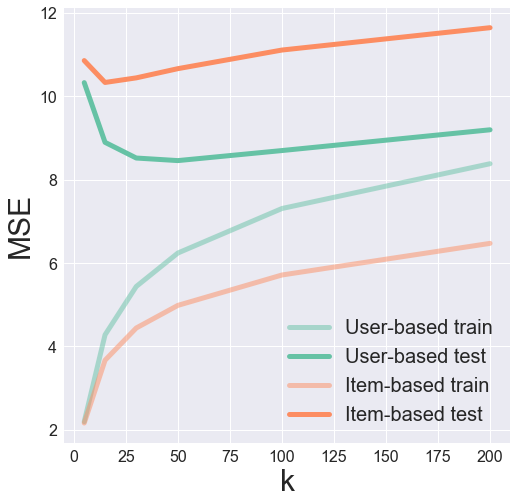

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

# Bias-subtracted Collaborative Filtering
考虑到可能存在用户会对所有的电影都打高分或者低分    
为了消除这种偏差，在预测评分时，其他用户u'减去各自的平均评分，在最后再加上预测用户u的平均评分  

In [31]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [33]:

user_pred = predict_nobias(train, user_similarity, kind='user')
print('Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test)))

item_pred = predict_nobias(train, item_similarity, kind='item')
print('Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test)))

Bias-subtracted User-based CF MSE: 10.2978888284
Bias-subtracted Item-based CF MSE: 11.5972520974


从效果上来看比top-k差一点，继续优化可以把top-k和这个方法结合起来

最后  
给定用户，我们可以推荐预测评价最高的几部电影  
给定电影，我们可以通过相似矩阵推荐与该电影最相似的几部电影
